In [186]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import random

#reference : https://medium.com/iet-vit/lets-build-a-rnn-pytorch-style-c960207f1fb3
#learn how to use RNN
#change the input to batch

In [199]:
a = torch.ones((2, 1))
print(a.shape)
a = a.squeeze(1)
print(a.shape)

torch.Size([2, 1])
torch.Size([2])


In [188]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim=hidden_dim
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        print(f"batch_size = {batch_size}")

        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        print(f"r_out={r_out.shape}, hidden_dim={self.hidden_dim}")
        # shape output to be (batch_size*seq_length, hidden_dim)

        r_out = r_out.reshape(-1, self.hidden_dim)

        # get final output
        output = self.fc(r_out)

        return output, hidden

In [189]:
input_size=1
output_size=1
hidden_dim=32
n_layers=1

seq_length = 20
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [190]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [191]:
time_after = 2
def train(rnn, batch, epoch, debug_mode= True):

    # initialize the hidden state
    hidden = None
    loss_sum = []

    for epoch_i in range(epoch):
        x_list = []
        y_list = []
        x_index = []
        for i in range(batch):
            i = epoch_i * random.random() + 2 + i
            time_steps = np.linspace(i * np.pi, (i+1)*np.pi, seq_length + time_after)
            x_index.append(torch.Tensor(time_steps)[:-1 * time_after])
            data = np.sin(time_steps)
            data.resize((seq_length + time_after)) # input_size=1
            # 取[0:seq_length]个点
            x = data[:-1 * time_after]
            # 取[time_after:seq_length + time_after]个点
            # 即y是x的time_after个时间后的数据
            y = data[time_after:]
            x_list.append(torch.Tensor(x).view(1, -1, 1))
            y_list.append(torch.Tensor(y).view(1, -1, 1))
        if debug_mode:
            pass
            # # 绘制拼接后的批量数据
            # x_index_p = torch.cat(x_index, dim=0).view(-1, 1)
            # batchX_p = torch.cat(x_list, dim=0).view(-1, 1)
            # plt.scatter(x_index_p, batchX_p)
        ## 对数据进行拼接，构造成批量数据
        # (batchSize, seqLength, inputSize)
        # seqLength 指的是Rnn中有多少个x，inputSize表示一个x用多少维的向量来表示, 这里我们是一个scalar值， 所以inputSize=1
        batchX = torch.cat(x_list, dim=0)
        batchY = torch.cat(y_list, dim=0)
        print(f"batchX.shape={batchX.shape}, batchY.shape={batchY.shape}")


        prediction, hidden = rnn(batchX, hidden)

        # Representing Memory #
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        print(f"prediction={prediction.shape}, batchY={batchY.shape}")
        # calculate the loss
        loss = criterion(prediction, batchY.view(-1, 1))
            # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()
        loss_sum.append(loss.item())
    return loss_sum, rnn, hidden
epoch_cnt = 40
loss_sum, trained_rnn, hidden = train(rnn, 1, epoch=epoch_cnt)

batchX.shape=torch.Size([1, 20, 1]), batchY.shape=torch.Size([1, 20, 1])
batch_size = 1
r_out=torch.Size([1, 20, 32]), hidden_dim=32
Parameter containing:
tensor([[ 0.0877, -0.1513,  0.1738, -0.0801, -0.0258,  0.0040,  0.0365, -0.1708,
          0.0768,  0.1503,  0.1103, -0.1055,  0.0598,  0.1333, -0.0711,  0.0643,
          0.0935, -0.0765,  0.1753,  0.0216, -0.1241, -0.1662, -0.0005, -0.1435,
         -0.1517,  0.0689, -0.0176,  0.1745, -0.1292,  0.1159,  0.0963, -0.0272]],
       requires_grad=True)
Parameter containing:
tensor([-0.0932], requires_grad=True)
prediction=torch.Size([20, 1]), batchY=torch.Size([1, 20, 1])
batchX.shape=torch.Size([1, 20, 1]), batchY.shape=torch.Size([1, 20, 1])
batch_size = 1
r_out=torch.Size([1, 20, 32]), hidden_dim=32
Parameter containing:
tensor([[ 0.0977, -0.1613,  0.1638, -0.0701, -0.0158,  0.0140,  0.0265, -0.1808,
          0.0668,  0.1603,  0.1003, -0.1155,  0.0498,  0.1233, -0.0611,  0.0743,
          0.1035, -0.0865,  0.1853,  0.0316, -0.1341,

40


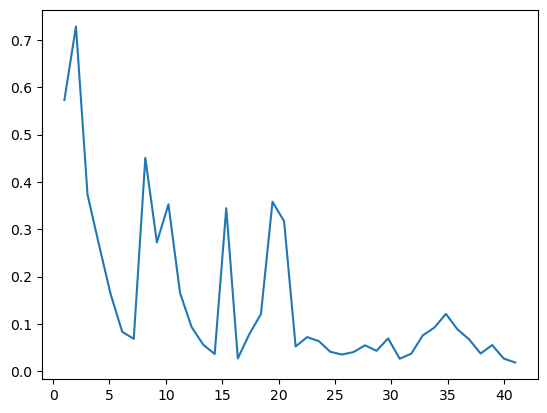

In [192]:
print(len(loss_sum))
cnt = np.linspace(1, epoch_cnt + 1, epoch_cnt)
plt.plot(cnt, loss_sum)


x=torch.Size([1, 20, 1]), hidden=torch.Size([1, 1, 32])
batch_size = 1
r_out=torch.Size([1, 20, 32]), hidden_dim=32
Parameter containing:
tensor([[ 0.2107, -0.2080,  0.1521, -0.0277, -0.0347, -0.0935, -0.0643, -0.2037,
          0.0700,  0.1052,  0.1253, -0.1832,  0.1296,  0.0568, -0.0477,  0.1098,
          0.2288, -0.1365,  0.1710,  0.1490, -0.1073, -0.2339,  0.0996, -0.1882,
         -0.0906,  0.0706, -0.1187,  0.2295, -0.0708,  0.1134,  0.1003, -0.0189]],
       requires_grad=True)
Parameter containing:
tensor([-0.0854], requires_grad=True)
pred=torch.Size([20, 1])


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

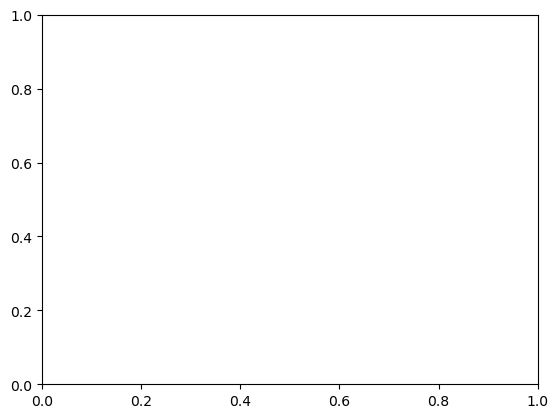

In [196]:
i = 50
time_steps = np.linspace(i * np.pi, (i+1)*np.pi, seq_length + time_after)
x_index = torch.Tensor(time_steps)[:-1 * time_after]
data = np.sin(time_steps)
data.resize((seq_length + time_after)) # input_size=1
# 取[0:seq_length]个点
x = data[:-1 * time_after]
# 取[time_after:seq_length + time_after]个点
# 即y是x的time_after个时间后的数据
y = data[time_after:]

x = torch.Tensor(x).view(1, seq_length, 1)
print(f"x={x.shape}, hidden={hidden.shape}")
pred, hidden_new = trained_rnn(x, hidden)
print(f"pred={pred.shape}")

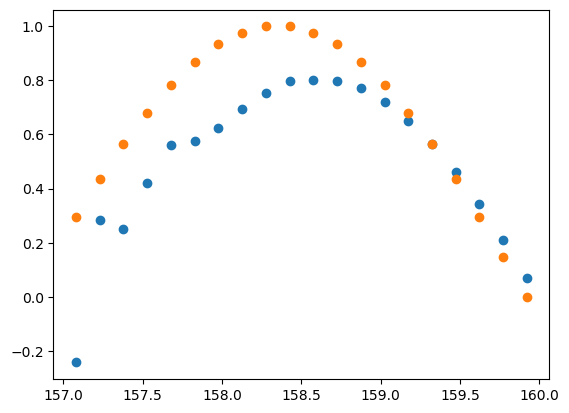

In [204]:
pred_data = pred.data
plt.scatter(x_index, pred_data.squeeze(1))
plt.scatter(x_index, y)